In [2]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

In [3]:
import os
import pandas as pd
import tensorflow as tf
import google.datalab.bigquery as dlbq
tf.__version__

'1.12.0'

---
##### From Jupyter notebook to python package
From exploration to production.

This little tool dumps a given function to a file with the same name in a certain package

In [4]:
PACKAGE="./train"
from tools import make_src_dumper
write_py = make_src_dumper(PACKAGE)

---
# Hypotheses, model function and custom estimator

#### The hypotheses
This computational graphs represent the trainable hypotheses

In [7]:
def hypothesis_linear(features, feature_columns, options):
    
    import tensorflow as tf

    all_feature_columns = feature_columns['wide'] + feature_columns['deep']
    
    input_layer = tf.feature_column.input_layer( 
        features, feature_columns=all_feature_columns)

    out = tf.layers.dense(input_layer, 1, activation=None)

    return out
    
write_py(hypothesis_linear)

'hypothesis_linear written to ./train/hypothesis_linear.py.'

In [8]:
def hypothesis_wd1(features, feature_columns, options):
    
    import tensorflow as tf

    
    wide_input_layer = tf.feature_column.input_layer( 
        features, feature_columns=feature_columns['wide'])

    deep_input_layer = tf.feature_column.input_layer( 
        features, feature_columns=feature_columns['deep'])

    # 40 x 20
    h1 = tf.layers.dense(deep_input_layer, 20, activation='relu')
    
    # 20 x 10
    h2 = tf.layers.dense(h1, 10, activation='relu')

    # 10 x 1
    o1 = tf.layers.dense(h2, 1, activation=None)

    o2 = tf.layers.dense(wide_input_layer, 1, activation=None)
    
    o = tf.concat([o1, o2], axis=1)
    
    hypothesis = tf.layers.dense(o, 1, activation=None)

    return hypothesis
    
write_py(hypothesis_wd1)

'hypothesis_wd1 written to ./train/hypothesis_wd1.py.'

In [9]:
from train.train_and_evaluate import train_and_evaluate

In [16]:
from train.train_tools import join_paths

args={}
args['base_dir']='gs://going-tfx/{}'.format(DATASET)
args['metadata_dir']='metadata'
args['train_data_pattern']='train_data/atl_june_tfr*'
args['eval_data_pattern']='eval_data/atl_june_tfr*'
args['train_batch_size']=1024
args['eval_batch_size']=512
args['max_train_steps']=10000
args['eval_steps']=10
args['learning_rate']=1e-3
args['model_dir']='model'
args['prefetch_buffer_size']=10000
args['distribute']=False

model_dir = os.path.join(args['base_dir'], args['model_dir'])
print("\n###############################################################################################################")
print("using directory {} to store the model. Remove the directory if you want to start from scratch".format(model_dir))
print("###############################################################################################################")
!gsutil -m rm -rf $model_dir

#
# You can't distribute work from a jupyter notebook. 
#
train_and_evaluate(join_paths(args))


###############################################################################################################
using directory gs://going-tfx/samples/model to store the model. Remove the directory if you want to start from scratch
###############################################################################################################
Removing gs://going-tfx/samples/model/#1542658828143669...
Removing gs://going-tfx/samples/model/export/exporter/1542648195/saved_model.pb#1542648212224678...
Removing gs://going-tfx/samples/model/checkpoint#1542658830831000...
Removing gs://going-tfx/samples/model/eval/events.out.tfevents.1542647252.kovalevskyi4#1542658842235001...
Removing gs://going-tfx/samples/model/export/exporter/#1542648197521922...
Removing gs://going-tfx/samples/model/events.out.tfevents.1542647210.kovalevskyi4#1542658858425052...
Removing gs://going-tfx/samples/model/export/exporter/1542648195/#1542648210269728...
Removing gs://going-tfx/samples/model/export/exporter/154

---
# Prediction 


#### Signature data for testing

First, let's get some test data. Now we need signature data, and that's what we have in Bigquery. Remember? 

In [33]:
from train.model_config import SIGNATURE_FLOAT_COLUMNS
from train.model_config import SIGNATURE_INT_COLUMNS
from train.model_config import SIGNATURE_STR_COLUMNS
from signature_queries import sample_query

SIGNATURE_COLUMNS = SIGNATURE_FLOAT_COLUMNS+SIGNATURE_INT_COLUMNS+SIGNATURE_STR_COLUMNS
signature_query=sample_query(SIGNATURE_COLUMNS, total=10000)
print(signature_query)
sample = dlbq.Query(signature_query).execute().result().to_dataframe()
print('Only {} examples. Showing first three:'.format(len(sample)))
sample[:3]


    SELECT
        DEP_LAT, DEP_LON, DEP_DELAY, MEAN_TEMP_DEP, MEAN_VIS_DEP, WND_SPD_DEP, ARR_LAT, ARR_LON, ARR_DELAY, MEAN_TEMP_ARR, MEAN_VIS_ARR, WND_SPD_ARR, DEP_DOW, DEP_T, ARR, AIRLINE
    FROM 
        `going-tfx.examples.ATL_JUNE_SIGNATURE` 
    where
        MOD(ABS(FARM_FINGERPRINT(
            CONCAT(DATE,AIRLINE,ARR)
        )) + DEP_T, 10000) >= 0 
    and
        MOD(ABS(FARM_FINGERPRINT(
            CONCAT( DATE, AIRLINE, ARR)
        )) + DEP_T, 10000) < 1 
    
Only 37 examples. Showing first three:


,DEP_LAT,DEP_LON,DEP_DELAY,MEAN_TEMP_DEP,MEAN_VIS_DEP,WND_SPD_DEP,ARR_LAT,ARR_LON,ARR_DELAY,MEAN_TEMP_ARR,MEAN_VIS_ARR,WND_SPD_ARR,DEP_DOW,DEP_T,ARR,AIRLINE
0,33.63,-84.42,1.0,83.9,10.0,6.2,40.77,-73.87,-2.0,80.7,8.9,5.7,1,2140,LGA,DL
1,33.63,-84.42,-3.0,71.0,9.9,6.0,37.13,-76.49,1.0,65.5,9.9,6.5,1,1130,PHF,FL
2,33.63,-84.42,-7.0,77.9,9.7,5.4,32.89,-80.04,-6.0,84.1,8.4,8.6,1,1505,CHS,DL


In [34]:
import json
samplefile='/tmp/test.json'
a_record = sample.to_dict(orient='records')[0]
a_record.pop('ARR_DELAY')
with open(samplefile, 'w') as f:
    f.write(json.dumps(a_record))
!cat $samplefile

{"WND_SPD_DEP": 6.2, "DEP_DELAY": 1.0, "ARR_LAT": 40.77, "WND_SPD_ARR": 5.7, "MEAN_VIS_DEP": 10.0, "DEP_T": 2140, "MEAN_TEMP_ARR": 80.7, "DEP_LON": -84.42, "DEP_DOW": 1, "MEAN_VIS_ARR": 8.9, "ARR": "LGA", "AIRLINE": "DL", "MEAN_TEMP_DEP": 83.9, "DEP_LAT": 33.63, "ARR_LON": -73.87}

---
#### Local prediction with gcloud ml-engine

In [35]:
all_versions = !gsutil ls $model_dir/export/exporter
all_versions[1:]

['gs://going-tfx/samples/model/export/exporter/1542638758/']

Choose your version from the above

In [36]:
latest_model=!gsutil ls gs://going-tfx/$DATASET/model/export/exporter | sort | tail -1
latest_model = latest_model[0]
latest_model

'gs://going-tfx/samples/model/export/exporter/1542638758/'

In [37]:
!gcloud ml-engine local predict \
  --model-dir=$latest_model \
  --json-instances=/tmp/test.json


OUTPUT
[18.346132278442383]


In [38]:
import json
samplefile='/tmp/test.json'
records = sample.to_dict(orient='records')[:20]
with open(samplefile, 'w') as f:
    for record in records:
        record.pop('ARR_DELAY')
        f.write(json.dumps(record))
        f.write('\n')
!cat $samplefile | tail -2

{"WND_SPD_DEP": 4.8, "DEP_DELAY": 102.0, "ARR_LAT": 36.89, "WND_SPD_ARR": 7.4, "MEAN_VIS_DEP": 8.7, "DEP_T": 1728, "MEAN_TEMP_ARR": 77.6, "DEP_LON": -84.42, "DEP_DOW": 4, "MEAN_VIS_ARR": 8.9, "ARR": "ORF", "AIRLINE": "EV", "MEAN_TEMP_DEP": 78.4, "DEP_LAT": 33.63, "ARR_LON": -76.2}
{"WND_SPD_DEP": 8.4, "DEP_DELAY": -2.0, "ARR_LAT": 26.68, "WND_SPD_ARR": 4.5, "MEAN_VIS_DEP": 8.5, "DEP_T": 1605, "MEAN_TEMP_ARR": 83.1, "DEP_LON": -84.42, "DEP_DOW": 4, "MEAN_VIS_ARR": 9.3, "ARR": "PBI", "AIRLINE": "DL", "MEAN_TEMP_DEP": 74.1, "DEP_LAT": 33.63, "ARR_LON": -80.09}


---
#### Predicting from within python code

In [49]:
models=!gsutil ls gs://going-tfx/samples/model/export/exporter | sort | tail -1
print(models)
latest_model=models[0]

['gs://going-tfx/samples/model/export/exporter/1542640488/']


In [47]:
estimator = tf.contrib.predictor.from_saved_model(latest_model)

INFO:tensorflow:Restoring parameters from gs://going-tfx/samples/model/export/exporter/1542640488/variables/variables


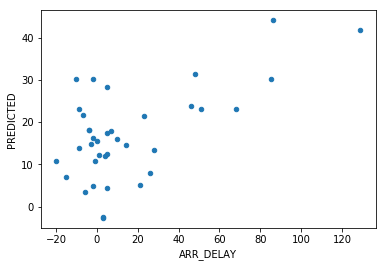

In [48]:
%matplotlib inline
compare=sample.copy()
predicted = estimator(sample.to_dict(orient='list'))
compare['PREDICTED'] = predicted['output']
compare.plot.scatter(x='ARR_DELAY', y='PREDICTED')

---
#### run the training locally

In [42]:
model_dir = 'gs://going-tfx/samples/model'
print("\n###############################################################################################################")
print("using directory {} to store the model. Remove the directory if you want to start from scratch".format(model_dir))
print("###############################################################################################################")
_ = !gsutil rm -rf $model_dir


###############################################################################################################
using directory gs://going-tfx/samples/model to store the model. Remove the directory if you want to start from scratch
###############################################################################################################


In [45]:
%%bash

# --distribute to use both GPUs with a resulting performance penalty - hence: Don't!

export PYTHONPATH=${PYTHONPATH}:${PWD}
python -m train.task \
  --base_dir=gs://going-tfx/samples/ \
  --metadata_dir=metadata \
  --train_data_pattern="train_data/atl_june_tfr*" \
  --eval_data_pattern="eval_data/atl_june_tfr*"  \
  --model_dir=model \
  --max_train_steps=20000 \
  --learning_rate=1e-3 \
  --job-dir=/tmp \
  --prefetch_buffer_size=10000

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5c89ecbb50>, '_model_dir': 'gs://going-tfx/samples/model/', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_global_id_in_cluster': 0, '_master': ''}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate 